# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.69905322284682

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [11]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    bias = []
    variance = []
    error = []
    t = []
    y_ind = []
    
    for i in range(num_runs):
        ind_bootstrap = np.random.choice(np.arange(len(y)), len(y))
        X_bp_train, y_bp_train = X[ind_bootstrap], y[ind_bootstrap]

        ind_test = np.setdiff1d(np.arange(len(y)), ind_bootstrap)
        X_bp_test, y_bp_test = X[ind_test], y[ind_test]

        h_model = regressor.fit(X_bp_train, y_bp_train)
        h = h_model.predict(X_bp_test)

        t = np.concatenate([t, h])
        y_ind = np.concatenate([y_ind, ind_test])

        error = np.concatenate([error, (h - y_bp_test) ** 2])
    
    bv = pd.DataFrame({'t':t, 'y_ind':y_ind})
    # выборочная дисперсия: взять каждый объект по индексам. У каждого индекса посчитать
    # дисперсию, усреднить

    variance = np.mean(bv.groupby(by=y_ind).var()['t'])    

    # смещение: по индексу взять все предсказания, среднее от них и вычесть правильный ответ.
    # это все в квадрате, потом взять среднее

    bias = np.mean((bv.groupby(by=y_ind).mean()['t'] - y[sorted(bv.y_ind.unique().astype(int))]) ** 2)
    
    return bias, variance, np.mean(error)
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [49]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

bias_lin, variance_lin, error_lin = compute_biase_variance(LinearRegression(), X, y)
bias_rf, variance_rf, error_rf = compute_biase_variance(RandomForestRegressor(), X, y)
bias_dt, variance_dt, error_dt = compute_biase_variance(DecisionTreeRegressor(), X, y)

CPU times: user 4min 15s, sys: 4.24 s, total: 4min 19s
Wall time: 4min 43s


In [13]:
# изи проверочка на это условие: 
# "В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!"

In [14]:
bias_lin + variance_lin, error_lin 

(24.82370846766273, 24.615503388505342)

In [15]:
bias_rf + variance_rf, error_rf

(12.84187109740098, 12.742264559841331)

In [16]:
bias_dt + variance_dt, error_dt

(23.405391111699885, 23.479014138162306)

In [17]:
# ура

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [18]:
# то есть мы оцениваем среднее не просто бустрапа, но теперь у нас каждая модель - это бутстрап

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import metrics

tree = BaggingRegressor(base_estimator=DecisionTreeRegressor())
rf = BaggingRegressor(base_estimator=RandomForestRegressor())
lr = BaggingRegressor(base_estimator=LinearRegression())

In [20]:
bias_lin, variance_lin, error_lin = compute_biase_variance(lr, X, y)
bias_rf, variance_rf, error_rf = compute_biase_variance(rf, X, y, num_runs=20)
bias_dt, variance_dt, error_dt = compute_biase_variance(tree, X, y)

In [21]:
bias_lin + variance_lin, error_lin

(24.783785004902292, 25.020805740892598)

In [22]:
bias_rf + variance_rf, error_rf

(12.937992422353682, 12.888730577714437)

In [23]:
bias_dt + variance_dt, error_dt

(13.91811263265826, 13.901352233065067)

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """
    ax = ax or plt.gca()
    np.random.seed(42)
    test_ind = np.random.choice(np.arange(len(y)), num_test_objects)
    
    X_test, y_test = X[test_ind], y[test_ind]

    train_ind = np.setdiff1d(np.arange(len(y)), test_ind)
    X_train, y_train = X[train_ind], y[train_ind]
    
    for i in range(num_runs):
        ind_bootstrap = np.random.choice(np.arange(len(y_train)), len(y_train))
        X_bp_train, y_bp_train = X[ind_bootstrap], y[ind_bootstrap]
    
        h_model = regressor.fit(X_bp_train, y_bp_train)
        h = h_model.predict(X_test)
        sns.scatterplot(np.arange(num_test_objects), h, color='blue', ax=ax)
        
    sns.scatterplot(np.arange(num_test_objects), y_test, color='black', ax=ax)
    ax.set_title(title)
    ax.set(xlabel='test', ylabel='b(x) prediction')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [31]:
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
lr = LinearRegression()

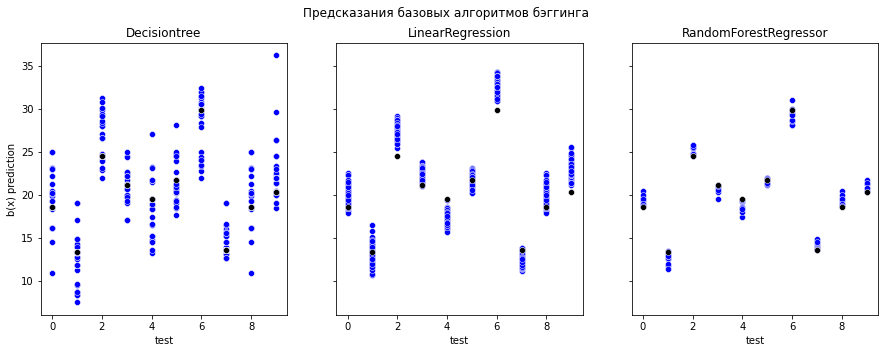

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# (ax1, ax2) = plt.subplots(2)
fig.suptitle('Предсказания базовых алгоритмов бэггинга')

plot_predictions(tree, X, y, num_runs=100, num_test_objects=10, title="Decisiontree", ax=ax1)
plot_predictions(lr, X, y, num_runs=100, num_test_objects=10, title="LinearRegression", ax=ax2)
plot_predictions(rf, X, y, num_runs=10, num_test_objects=10, title="RandomForestRegressor", ax=ax3)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

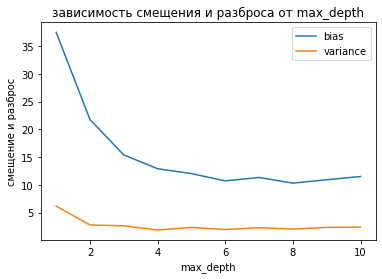

In [56]:
bias = []
variance = []
for depth in range(1, 11):
    rf = RandomForestRegressor(max_depth=depth)
    bias_rf, variance_rf, _ = compute_biase_variance(rf, X, y, num_runs=20)
    bias.append(bias_rf)
    variance.append(variance_rf)
    
sns.lineplot(np.arange(1,11), bias, label='bias')
sns.lineplot(np.arange(1,11), variance, label='variance')
plt.title('зависимость смещения и разброса от max_depth')
plt.xlabel('max_depth')
plt.ylabel('смещение и разброс')
plt.legend()
plt.show()

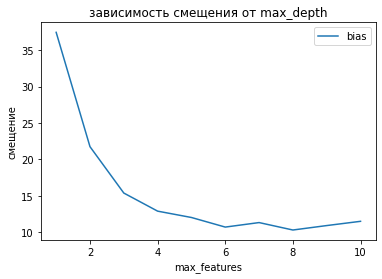

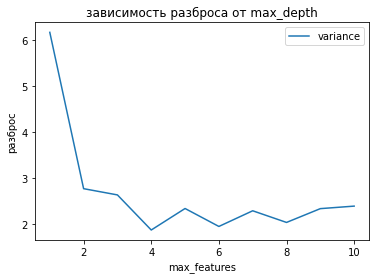

In [58]:
sns.lineplot(np.arange(1,11), bias, label='bias')
plt.title('зависимость смещения от max_depth')
plt.xlabel('max_features')
plt.ylabel('смещение')
plt.legend()
plt.show()

sns.lineplot(np.arange(1,11), variance, label='variance')
plt.title('зависимость разброса от max_depth')
plt.xlabel('max_features')
plt.ylabel('разброс')
plt.legend()
plt.show()

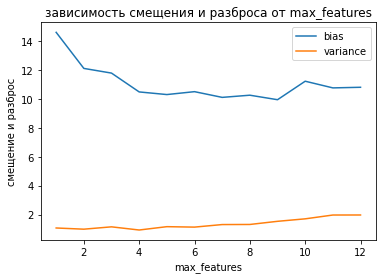

In [54]:
bias = []
variance = []
for feature in range(1, X.shape[1]):
    rf = RandomForestRegressor(max_features=feature)
    bias_rf, variance_rf, _ = compute_biase_variance(rf, X, y, num_runs=20)
    bias.append(bias_rf)
    variance.append(variance_rf)
    
sns.lineplot(np.arange(1, X.shape[1]), bias, label='bias')
sns.lineplot(np.arange(1, X.shape[1]), variance, label='variance')
plt.title('зависимость смещения и разброса от max_features')
plt.xlabel('max_features')
plt.ylabel('смещение и разброс')
plt.legend()
plt.show()
        

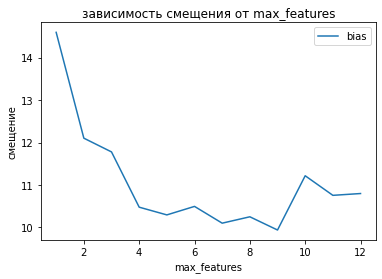

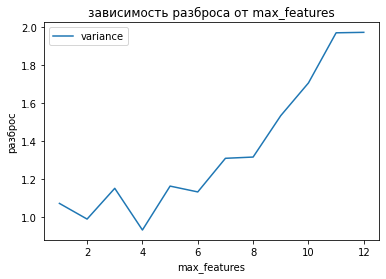

In [55]:
sns.lineplot(np.arange(1, X.shape[1]), bias, label='bias')
plt.title('зависимость смещения от max_features')
plt.xlabel('max_features')
plt.ylabel('смещение')
plt.legend()
plt.show()

sns.lineplot(np.arange(1, X.shape[1]), variance, label='variance')
plt.title('зависимость разброса от max_features')
plt.xlabel('max_features')
plt.ylabel('разброс')
plt.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

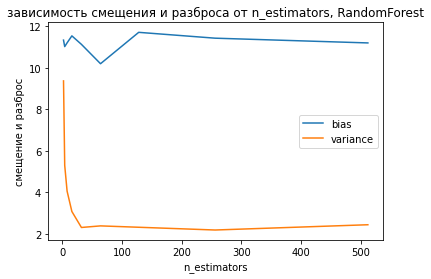

In [59]:
bias = []
variance = []
n_estimators_ = 2**np.arange(1, 10)
for n in n_estimators_:
    rf = RandomForestRegressor(n_estimators=n)
    bias_rf, variance_rf, _ = compute_biase_variance(rf, X, y, num_runs=20)
    bias.append(bias_rf)
    variance.append(variance_rf)
    
sns.lineplot(n_estimators_, bias, label='bias')
sns.lineplot(n_estimators_, variance, label='variance')
plt.title('зависимость смещения и разброса от n_estimators, RandomForest')
plt.xlabel('n_estimators')
plt.ylabel('смещение и разброс')
plt.legend()
plt.show()

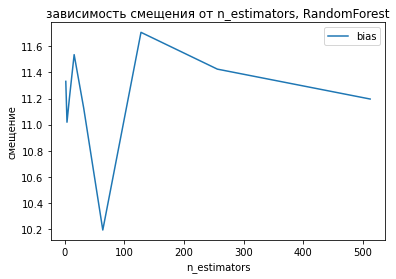

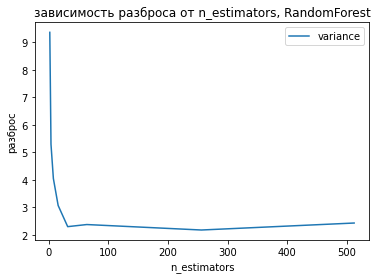

In [60]:
# по отдельности
sns.lineplot(n_estimators_, bias, label='bias')
plt.title('зависимость смещения от n_estimators, RandomForest')
plt.xlabel('n_estimators')
plt.ylabel('смещение')
plt.legend()
plt.show()


sns.lineplot(n_estimators_, variance, label='variance')
plt.title('зависимость разброса от n_estimators, RandomForest')
plt.xlabel('n_estimators')
plt.ylabel('разброс')
plt.legend()
plt.show()

In [46]:
# !brew install libomp
# ! pip install xgboost

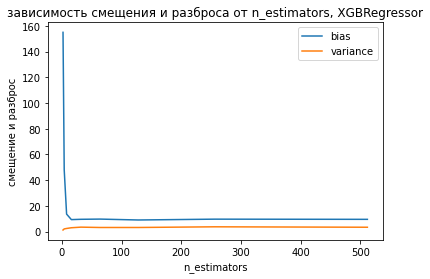

In [52]:
import xgboost as xgb

bias = []
variance = []
n_estimators_ = 2**np.arange(1, 10)
for n in n_estimators_:
    boosting = xgb.XGBRegressor(n_estimators=n)
    bias_rf, variance_rf, _ = compute_biase_variance(boosting, X, y, num_runs=20)
    bias.append(bias_rf)
    variance.append(variance_rf)
    
sns.lineplot(n_estimators_, bias, label='bias')
sns.lineplot(n_estimators_, variance, label='variance')
plt.title('зависимость смещения и разброса от n_estimators, XGBRegressor')
plt.xlabel('n_estimators')
plt.ylabel('смещение и разброс')
plt.legend()
plt.show()

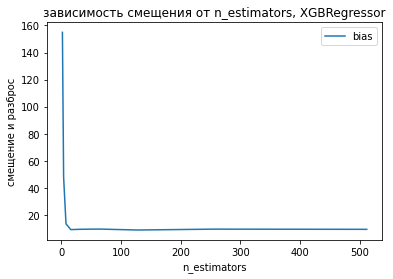

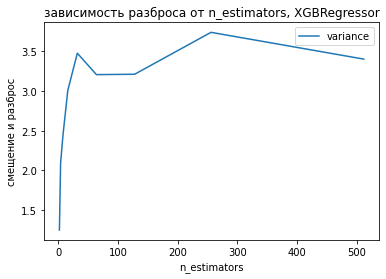

In [53]:
# по отдельности
sns.lineplot(n_estimators_, bias, label='bias')
plt.title('зависимость смещения от n_estimators, XGBRegressor')
plt.xlabel('n_estimators')
plt.ylabel('смещение')
plt.legend()
plt.show()


sns.lineplot(n_estimators_, variance, label='variance')
plt.title('зависимость разброса от n_estimators, XGBRegressor')
plt.xlabel('n_estimators')
plt.ylabel('разброс')
plt.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.